In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pk
from collections import defaultdict
import re

from sentence_transformers import SentenceTransformer
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import confusion_matrix

/Users/snath/Nextcloud/Documents/PhD/Code/projects/process_modelling/process_modelling/.env_process_modelling/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
def get_clusters(embeddings, texts, cluster_assignment, printclusters):
    """Helper function for perform_hierarchicalClustering()
    Args:
        embeddings (list): List of embeddings
        texts (list): List of texts
        cluster_assignment (list): cluster assignment for each text/embedding
        printcluster (bool): True will print all texts in each cluster
    Returns:
        response_to_cluster dict: text to cluster number
        cluster_to_response dict: cluster number to list of texts in that cluster
        num_clusters int: number of clusters
        min_similarities dict: cluster to min text similiarity
    """

    cluster_to_response = defaultdict(list)                                 # make cluster_to_response
    cluster_to_embeddings = defaultdict(list)                               # make cluster_to_embeddings (used for min sim)
    for ind, cluster_num in enumerate(cluster_assignment):
        cluster_to_response[cluster_num].append(texts[ind])
        cluster_to_embeddings[cluster_num].append(embeddings[ind])
    
    response_to_cluster = dict(zip(texts, cluster_assignment))              # make response_to_cluster 
    
    num_clusters = len(np.unique(cluster_assignment))                       # find num clusters

    min_similarities = {}                                                   # find min paiwise text similarity in each cluster
    for cl in cluster_to_embeddings:
        stacked = np.array(cluster_to_embeddings[cl])
        sim = stacked @ stacked.T
        np.fill_diagonal(sim, np.inf)
        min_sim = np.min(sim)
        min_similarities[cl] = min_sim
    
    if printclusters:                                                       # print clusters if True
        for cluster_num, responses in cluster_to_response.items():
            print(f"Cluster {cluster_num}")
            print(responses, end="\n\n")

    return response_to_cluster, cluster_to_response, num_clusters, min_similarities

def perform_hierarchicalClustering(embeddings, texts, ax, cut_off_distance, printclusters):
    """Performs hierarchical clustering
    Args:
        embeddings (list): List of embeddings
        texts (list): List of texts
        ax: axes for plotting
        cut_off_distance (float): distance threshold for hierarchical clustering
        printcluster (bool): True will print all texts in each cluster
    Calls:
        get_clusters()
    """
    linked = linkage(embeddings, 'ward')                                                                                                    # 'ward' distance for measuring distance between clusters
    dendrogram(linked, orientation='top', labels=texts, distance_sort='descending', show_leaf_counts=False, no_labels=True, ax=ax[0])       # Make dendogram
    
    # Elbow plot -- Plot mean minsim/number of clusters as a fn of cut-off distance
    mean_minsemsim = []
    num_clusters = []
    for cod in np.linspace(1, 8, 30):
        cluster_assignment = fcluster(linked, t=cod, criterion='distance')
        _, _, _, minsims = get_clusters(embeddings, texts, cluster_assignment, False)
        mean_minsemsim.append(np.mean(list(minsims.values())))
        num_clusters.append(len(np.unique(cluster_assignment)))
    ax[1].plot(np.linspace(1, 8, 30), mean_minsemsim)
    ax[1].set_xlabel("Cut-off distance"); ax[1].set_ylabel("Mean cluster semantic similarity")
    ax[2].plot(np.linspace(1, 8, 30), num_clusters)
    ax[2].set_xlabel("Cut-off distance"); ax[2].set_ylabel("Number of clusters")

    cluster_assignment = fcluster(linked, t=cut_off_distance, criterion='distance')         # assign clusters using the decided cut_off_distance
    return get_clusters(embeddings, texts, cluster_assignment, printclusters)

def calculate_cosine_similarity(embedding1, embedding2):
    """Calculates cosine similarity between two embeddings
    Args:
        embedding1: first embedding
        embedding2: second embedding
    Returns:
        cosine similarity
    """
    if np.any(embedding1) and np.any(embedding2):
        return np.dot(embedding1, embedding2)       # embeddings are already normalised so no need to divide by norm
    else:
        return 0

def normalize(embedding):
    norm = np.linalg.norm(embedding)
    if norm == 0:
        return embedding  # Return as-is if it's a zero vector
    return embedding / norm

def get_similarity_matrix(embeddings):
    embedding_matrix = np.array(embeddings)
    # Since embeddings are already normalized, the cosine similarity is just the dot product
    similarity_matrix = np.dot(embedding_matrix, embedding_matrix.T)
    return similarity_matrix

def plot_heatmap(matrix, texts, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, cmap="coolwarm", annot=True)
    plt.title(title)
    plt.show()

def write_category_SS_jump_filterorder0_autbrick(data, model, context):
    # write category using response_to_cluster
    data.loc[data["task"] == 2, f"category_{model}_{context}"] = data[data["task"] == 2]["response"].apply(lambda x: response_to_cluster_autbrick.get(x))
    # data.loc[data["task"] == 3, f"category_{model}_{context}"] = data[data["task"] == 3]["response"].apply(lambda x: response_to_cluster_autpaperclip.get(x))
    # data.loc[data["task"] == 1, f"category_{model}_{context}"] = data[data["task"] == 1]["response"].apply(lambda x: response_to_cluster_vf.get(x))

    # write semantic similarity using calculate_cosine_similarity
    data.loc[data["task"] == 2, f'SS_{model}_{context}'] = data[data["task"] == 2].apply(lambda row: calculate_cosine_similarity(embeddings[f"autbrick_{model}_{context}"].get(row['response']), embeddings[f"autbrick_{model}_{context}"].get(row['previous_response'])), axis=1)
    # data.loc[data["task"] == 3, f'SS_{model}_{context}'] = data[data["task"] == 3].apply(lambda row: calculate_cosine_similarity(embeddings[f"autpaperclip_{model}_{context}"].get(row['response']), embeddings[f"autpaperclip_{model}_{context}"].get(row['previous_response'])), axis=1)
    # data.loc[data["task"] == 1, f'SS_{model}_{context}'] = data[data["task"] == 1].apply(lambda row: calculate_cosine_similarity(embeddings[f"vf_{model}_{context}"].get(row['response']), embeddings[f"vf_{model}_{context}"].get(row['previous_response'])), axis=1)

    # write jump as described in Figure above
    # data[f"category_{model}_{context}"] = data[f"category_{model}_{context}"].astype(int)
    data[f"jump_cat_{model}_{context}"] = (~(data[f"category_{model}_{context}"].diff() == 0)).astype(int)
    data[f"jump_SS_{model}_{context}"] = (data[f"SS_{model}_{context}"] < 0.8).astype(int)
    data[f'jump_{model}_{context}'] = data[f"jump_cat_{model}_{context}"] & data[f"jump_SS_{model}_{context}"]

    data = data[data["order"] > 0]      # remove the first response

    return data

def write_category_SS_jump_filterorder0_vf(data, model, context):
    # write category using response_to_cluster
    # data.loc[data["task"] == 2, f"category_{model}_{context}"] = data[data["task"] == 2]["response"].apply(lambda x: response_to_cluster_autbrick.get(x))
    # data.loc[data["task"] == 3, f"category_{model}_{context}"] = data[data["task"] == 3]["response"].apply(lambda x: response_to_cluster_autpaperclip.get(x))
    data.loc[data["task"] == 1, f"category_{model}_{context}"] = data[data["task"] == 1]["response"].apply(lambda x: response_to_cluster_vf.get(x))

    # write semantic similarity using calculate_cosine_similarity
    # data.loc[data["task"] == 2, f'SS_{model}_{context}'] = data[data["task"] == 2].apply(lambda row: calculate_cosine_similarity(embeddings[f"autbrick_{model}_{context}"].get(row['response']), embeddings[f"autbrick_{model}_{context}"].get(row['previous_response'])), axis=1)
    # data.loc[data["task"] == 3, f'SS_{model}_{context}'] = data[data["task"] == 3].apply(lambda row: calculate_cosine_similarity(embeddings[f"autpaperclip_{model}_{context}"].get(row['response']), embeddings[f"autpaperclip_{model}_{context}"].get(row['previous_response'])), axis=1)
    data.loc[data["task"] == 1, f'SS_{model}_{context}'] = data[data["task"] == 1].apply(lambda row: calculate_cosine_similarity(embeddings[f"vf_{model}_{context}"].get(row['response']), embeddings[f"vf_{model}_{context}"].get(row['previous_response'])), axis=1)

    # write jump as described in Figure above
    # data[f"category_{model}_{context}"] = data[f"category_{model}_{context}"].astype(int)
    data[f"jump_cat_{model}_{context}"] = (~(data[f"category_{model}_{context}"].diff() == 0)).astype(int)
    data[f"jump_SS_{model}_{context}"] = (data[f"SS_{model}_{context}"] < 0.8).astype(int)
    data[f'jump_{model}_{context}'] = data[f"jump_cat_{model}_{context}"] & data[f"jump_SS_{model}_{context}"]

    data = data[data["order"] > 0]      # remove the first response

    return data

def get_jump_agreement(data, task, jumpcol1, jumpcol2):
    cm = confusion_matrix(data[data["task"] == task][jumpcol1], data[data["task"] == task][jumpcol2])
    print(cm)
    TN, FP, FN, TP = cm.ravel()

    # Calculate TPR, FPR, TNR, FNR
    TPR = TP / (TP + FN)  # Sensitivity, Recall
    FPR = FP / (FP + TN)
    TNR = TN / (TN + FP)  # Specificity
    FNR = FN / (TP + FN)

    print(f"True Positive Rate (TPR): {TPR:.2f}")
    print(f"True Negative Rate (TNR): {TNR:.2f}")
    print(f"False Positive Rate (FPR): {FPR:.2f}")
    print(f"False Negative Rate (FNR): {FNR:.2f}")

In [3]:
data = pd.read_csv("../csvs/data_humans_allresponses.csv")
texts_autbrick = data[data["task"] == 2]["response"].unique().tolist()
texts_autpaperclip = data[data["task"] == 3]["response"].unique().tolist()
texts_vf = data[data["task"] == 1]["response"].unique().tolist()
texts = [texts_autbrick, texts_autpaperclip, texts_vf]
tasks = ["autbrick", "autpaperclip", "vf"]

In [4]:
models = ["qwen", "stella", "gtelarge", "jxm"]
contexts = ["animal", "pet", "brick", "paperclip"]

In [5]:
embeddings = {}                   # [[autbrick_qwen_nocontext, autbrick_qwen_nearcontext, autbrick_qwen_farcontext, autbrick_stellanocontext, autbrick_qwen_nearcontext, autbrick_qwen_farcontext], [], []]
near_context = ["brick", "paperclip", "animal"]
far_context = ["animal", "brick", "paperclip"]

for model in models:
    print(model)
    context_embeddings = pk.load(open(f"../embeddings/embeddings_{model}_contexts.pk", "rb"))
    for i, textset in enumerate(texts):
        embedding_dict = pk.load(open(f"../embeddings/embeddings_{model}_{tasks[i]}.pk", "rb"))
        embeddings[f"{tasks[i]}_{model}_nocontext"] = embedding_dict
        embeddings[f"{tasks[i]}_{model}_nearcontext"] = dict(zip(texts[i], [normalize(embedding_dict[t] + context_embeddings[near_context[i]]) for t in texts[i]]))
        embeddings[f"{tasks[i]}_{model}_farcontext"] = dict(zip(texts[i], [normalize(embedding_dict[t] + context_embeddings[far_context[i]]) for t in texts[i]]))

        # simmat = get_similarity_matrix([embedding_dict[t] for t in texts[i]])
        # plot_heatmap(simmat, texts[i], f"{model}, {tasks[i]}")

qwen
stella
gtelarge
jxm


In [6]:
printclusters = True

Cluster 23
['house', 'bridge', 'houses', 'terraced houses', 'building shops', 'build house', 'build bridge', 'make fort', 'castle', 'villa', 'roof', 'block ant nest', 'build', 'make building', 'building bridges', 'make pyramid', 'build tower', 'build shed', 'trap/block ants', 'hut', 'builder', 'renovate', 'build hut', 'stick photo put cupboard', 'house front', 'make house', 'terrace', 'make partitions', 'dollhouse wall', 'cupboard', 'make cupboard', 'build roof', 'build garden shed', 'building', 'construction', 'birdhouse', 'build villa', 'build cellar', 'repair structures', 'build birdbath', 'shed', 'build cupboard', 'build kitchen', 'block', 'build track', 'build stone tower', 'make tower', 'building building', 'garden shed', 'make hut', 'build restaurant', 'build theater', 'build skyscraper', 'build room', 'build nursing home', 'build cinema', 'treehouse', 'closet', 'building house', 'build fort', 'make edge', 'make bathroom', 'building castle', 'pyramid building', 'building library

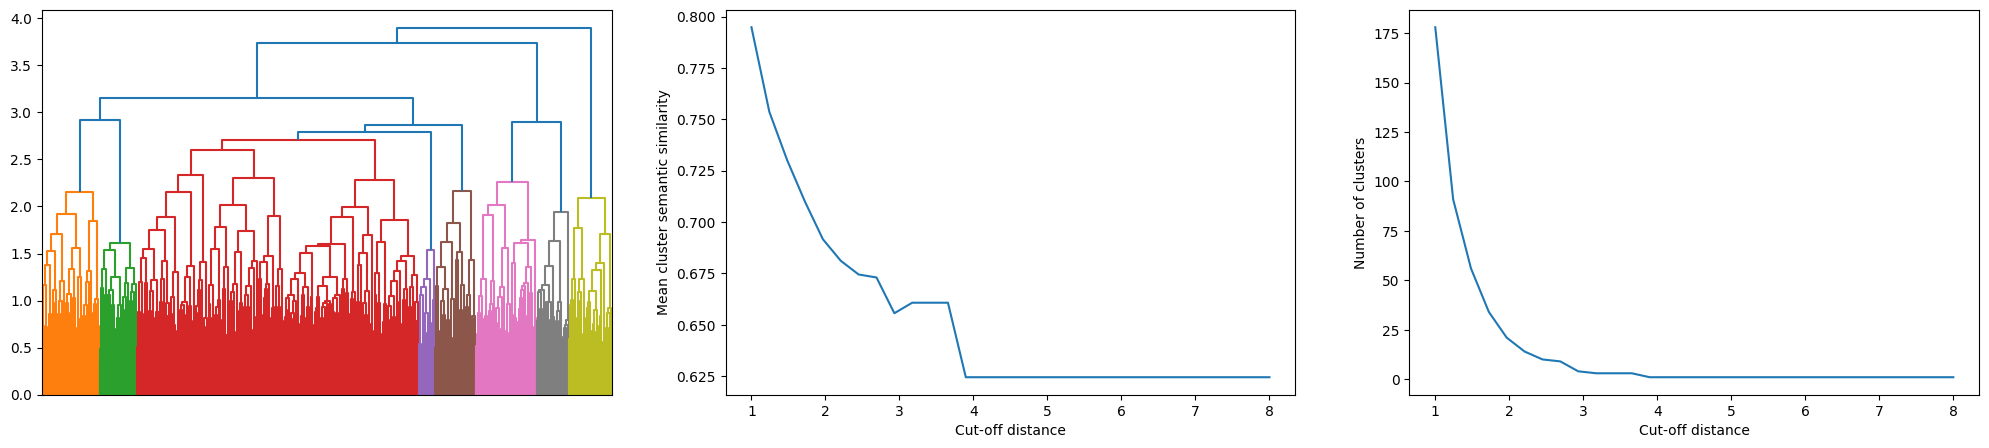

In [7]:
model = "gtelarge"
context = "nocontext"

fig, ax = plt.subplots(1, 3, figsize=(25, 5))
response_to_cluster_autbrick, cluster_to_response_autbrick, num_clusters_autbrick, minsim_autbrick = perform_hierarchicalClustering(list(embeddings[f"autbrick_{model}_{context}"].values()), texts_autbrick, ax, 1.89, printclusters)
print("Num clusters =", num_clusters_autbrick)
print(np.min(list(minsim_autbrick.values())), np.mean(list(minsim_autbrick.values())))

data = write_category_SS_jump_filterorder0_autbrick(data, model, context)

Cluster 23
['house', 'bridge', 'houses', 'terraced houses', 'building shops', 'build house', 'build bridge', 'make fort', 'castle', 'villa', 'roof', 'block ant nest', 'build', 'make building', 'building bridges', 'make pyramid', 'build tower', 'build shed', 'trap/block ants', 'hut', 'builder', 'renovate', 'build hut', 'stick photo put cupboard', 'house front', 'make house', 'terrace', 'make partitions', 'dollhouse wall', 'cupboard', 'make cupboard', 'build roof', 'build garden shed', 'building', 'construction', 'birdhouse', 'build villa', 'build cellar', 'repair structures', 'build birdbath', 'shed', 'build cupboard', 'build kitchen', 'block', 'build track', 'build stone tower', 'make tower', 'building building', 'garden shed', 'make hut', 'build restaurant', 'build theater', 'build skyscraper', 'build room', 'build nursing home', 'build cinema', 'treehouse', 'closet', 'building house', 'build fort', 'make edge', 'make bathroom', 'building castle', 'pyramid building', 'building library

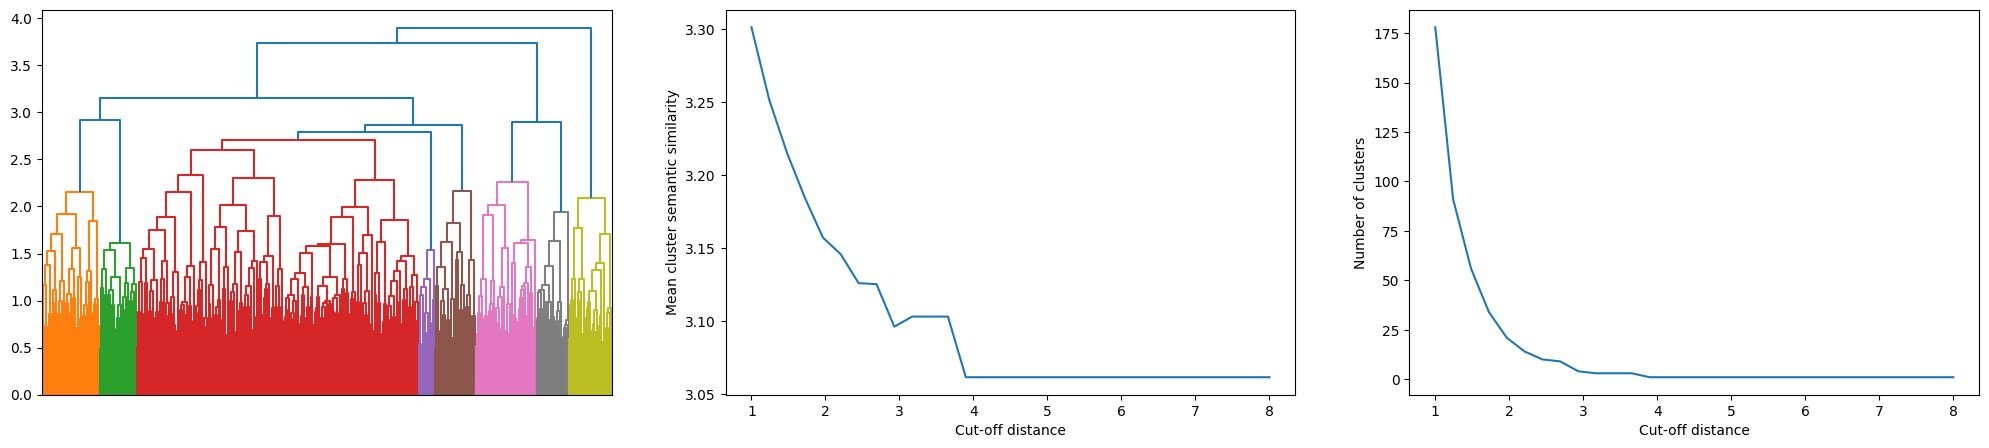

In [9]:
model = "gtelarge"
context = "nearcontext"

fig, ax = plt.subplots(1, 3, figsize=(25, 5))
response_to_cluster_autbrick, cluster_to_response_autbrick, num_clusters_autbrick, minsim_autbrick = perform_hierarchicalClustering(list(embeddings[f"autbrick_{model}_{context}"].values()), texts_autbrick, ax, 1.89, printclusters)
print("Num clusters =", num_clusters_autbrick)
print(np.min(list(minsim_autbrick.values())), np.mean(list(minsim_autbrick.values())))

data = write_category_SS_jump_filterorder0_autbrick(data, model, context)

In [ ]:
model = "gtelarge"
context = "farcontext"

fig, ax = plt.subplots(1, 3, figsize=(25, 5))
response_to_cluster_autbrick, cluster_to_response_autbrick, num_clusters_autbrick, minsim_autbrick = perform_hierarchicalClustering(list(embeddings[f"autbrick_{model}_{context}"].values()), texts_autbrick, ax, 1.015, printclusters)
print("Num clusters =", num_clusters_autbrick)
print(np.min(list(minsim_autbrick.values())), np.mean(list(minsim_autbrick.values())))

data = write_category_SS_jump_filterorder0_autbrick(data, model, context)

In [ ]:
model = "stella"
context = "nocontext"

fig, ax = plt.subplots(1, 3, figsize=(25, 5))
response_to_cluster_autbrick, cluster_to_response_autbrick, num_clusters_autbrick, minsim_autbrick = perform_hierarchicalClustering(list(embeddings[f"autbrick_{model}_{context}"].values()), texts_autbrick, ax, 2.7, printclusters)
print("Num clusters =", num_clusters_autbrick)
print(np.min(list(minsim_autbrick.values())), np.mean(list(minsim_autbrick.values())))

data = write_category_SS_jump_filterorder0_autbrick(data, model, context)

In [ ]:
model = "stella"
context = "nearcontext"

fig, ax = plt.subplots(1, 3, figsize=(25, 5))
response_to_cluster_autbrick, cluster_to_response_autbrick, num_clusters_autbrick, minsim_autbrick = perform_hierarchicalClustering(list(embeddings[f"autbrick_{model}_{context}"].values()), texts_autbrick, ax, 1.68, printclusters)
print("Num clusters =", num_clusters_autbrick)
print(np.min(list(minsim_autbrick.values())), np.mean(list(minsim_autbrick.values())))

data = write_category_SS_jump_filterorder0_autbrick(data, model, context)

In [ ]:
model = "stella"
context = "farcontext"

fig, ax = plt.subplots(1, 3, figsize=(25, 5))
response_to_cluster_autbrick, cluster_to_response_autbrick, num_clusters_autbrick, minsim_autbrick = perform_hierarchicalClustering(list(embeddings[f"autbrick_{model}_{context}"].values()), texts_autbrick, ax, 1.74, printclusters)
print("Num clusters =", num_clusters_autbrick)
print(np.min(list(minsim_autbrick.values())), np.mean(list(minsim_autbrick.values())))

data = write_category_SS_jump_filterorder0_autbrick(data, model, context)

In [ ]:
model = "gtelarge"
context = "nocontext"

fig, ax = plt.subplots(1, 3, figsize=(25, 5))
response_to_cluster_vf, cluster_to_response_vf, num_clusters_vf, minsim_vf = perform_hierarchicalClustering(list(embeddings[f"vf_{model}_{context}"].values()), texts_vf, ax, 1.065, printclusters)
print("Num clusters =", num_clusters_vf)
print(np.min(list(minsim_vf.values())), np.mean(list(minsim_vf.values())))

data = write_category_SS_jump_filterorder0_vf(data, model, context)

In [ ]:
model = "gtelarge"
context = "nearcontext"

fig, ax = plt.subplots(1, 3, figsize=(25, 5))
response_to_cluster_vf, cluster_to_response_vf, num_clusters_vf, minsim_vf = perform_hierarchicalClustering(list(embeddings[f"vf_{model}_{context}"].values()), texts_vf, ax, 0.56, printclusters)
print("Num clusters =", num_clusters_vf)
print(np.min(list(minsim_vf.values())), np.mean(list(minsim_vf.values())))

data = write_category_SS_jump_filterorder0_vf(data, model, context)

In [ ]:
model = "gtelarge"
context = "farcontext"

fig, ax = plt.subplots(1, 3, figsize=(25, 5))
response_to_cluster_vf, cluster_to_response_vf, num_clusters_vf, minsim_vf = perform_hierarchicalClustering(list(embeddings[f"vf_{model}_{context}"].values()), texts_vf, ax, 0.562, printclusters)
print("Num clusters =", num_clusters_vf)
print(np.min(list(minsim_vf.values())), np.mean(list(minsim_vf.values())))

data = write_category_SS_jump_filterorder0_vf(data, model, context)

In [ ]:
model = "stella"
context = "nocontext"

fig, ax = plt.subplots(1, 3, figsize=(25, 5))
response_to_cluster_vf, cluster_to_response_vf, num_clusters_vf, minsim_vf = perform_hierarchicalClustering(list(embeddings[f"vf_{model}_{context}"].values()), texts_vf, ax, 1.422, printclusters)
print("Num clusters =", num_clusters_vf)
print(np.min(list(minsim_vf.values())), np.mean(list(minsim_vf.values())))

data = write_category_SS_jump_filterorder0_vf(data, model, context)

In [ ]:
model = "stella"
context = "nearcontext"

fig, ax = plt.subplots(1, 3, figsize=(25, 5))
response_to_cluster_vf, cluster_to_response_vf, num_clusters_vf, minsim_vf = perform_hierarchicalClustering(list(embeddings[f"vf_{model}_{context}"].values()), texts_vf, ax, 0.86, printclusters)
print("Num clusters =", num_clusters_vf)
print(np.min(list(minsim_vf.values())), np.mean(list(minsim_vf.values())))

data = write_category_SS_jump_filterorder0_vf(data, model, context)

In [ ]:
model = "stella"
context = "farcontext"

fig, ax = plt.subplots(1, 3, figsize=(25, 5))
response_to_cluster_vf, cluster_to_response_vf, num_clusters_vf, minsim_vf = perform_hierarchicalClustering(list(embeddings[f"vf_{model}_{context}"].values()), texts_vf, ax, 0.912, printclusters)
print("Num clusters =", num_clusters_vf)
print(np.min(list(minsim_vf.values())), np.mean(list(minsim_vf.values())))

data = write_category_SS_jump_filterorder0_vf(data, model, context)

In [ ]:
model1 = "gtelarge"
context1 = "nocontext"
model2 = "gtelarge"
context2 = "nearcontext"

get_jump_agreement(data, 2, f"jump_cat_{model1}_{context1}", f"jump_cat_{model2}_{context2}")

In [ ]:
model1 = "gtelarge"
context1 = "nocontext"
model2 = "gtelarge"
context2 = "farcontext"

get_jump_agreement(data, 2, f"jump_cat_{model1}_{context1}", f"jump_cat_{model2}_{context2}")

In [ ]:
model1 = "gtelarge"
context1 = "nearcontext"
model2 = "gtelarge"
context2 = "farcontext"

get_jump_agreement(data, 2, f"jump_cat_{model1}_{context1}", f"jump_cat_{model2}_{context2}")

In [ ]:
model1 = "stella"
context1 = "nocontext"
model2 = "stella"
context2 = "nearcontext"

get_jump_agreement(data, 2, f"jump_cat_{model1}_{context1}", f"jump_cat_{model2}_{context2}")

In [ ]:
model1 = "stella"
context1 = "nocontext"
model2 = "stella"
context2 = "farcontext"

get_jump_agreement(data, 2, f"jump_cat_{model1}_{context1}", f"jump_cat_{model2}_{context2}")

In [ ]:
model1 = "stella"
context1 = "nearcontext"
model2 = "stella"
context2 = "farcontext"

get_jump_agreement(data, 2, f"jump_cat_{model1}_{context1}", f"jump_cat_{model2}_{context2}")

In [ ]:
model1 = "gtelarge"
context1 = "nocontext"
model2 = "stella"
context2 = "nocontext"

get_jump_agreement(data, 2, f"jump_cat_{model1}_{context1}", f"jump_cat_{model2}_{context2}")

In [ ]:
model1 = "gtelarge"
context1 = "nearcontext"
model2 = "stella"
context2 = "nearcontext"

get_jump_agreement(data, 2, f"jump_cat_{model1}_{context1}", f"jump_cat_{model2}_{context2}")

In [ ]:
model1 = "gtelarge"
context1 = "farcontext"
model2 = "stella"
context2 = "farcontext"

get_jump_agreement(data, 2, f"jump_cat_{model1}_{context1}", f"jump_cat_{model2}_{context2}")

In [ ]:
model1 = "gtelarge"
context1 = "nocontext"
model2 = "gtelarge"
context2 = "nearcontext"

get_jump_agreement(data, 1, f"jump_cat_{model1}_{context1}", f"jump_cat_{model2}_{context2}")

In [ ]:
model1 = "gtelarge"
context1 = "nocontext"
model2 = "gtelarge"
context2 = "farcontext"

get_jump_agreement(data, 1, f"jump_cat_{model1}_{context1}", f"jump_cat_{model2}_{context2}")

In [ ]:
model1 = "gtelarge"
context1 = "nearcontext"
model2 = "gtelarge"
context2 = "farcontext"

get_jump_agreement(data, 1, f"jump_cat_{model1}_{context1}", f"jump_cat_{model2}_{context2}")

In [10]:
model1 = "gtelarge"
context1 = "nocontext"
model2 = "stella"
context2 = "nocontext"

get_jump_agreement(data, 1, f"jump_cat_{model1}_{context1}", f"jump_cat_{model2}_{context2}")

KeyError: 'jump_cat_stella_nocontext'

In [ ]:
model1 = "gtelarge"
context1 = "nearcontext"
model2 = "stella"
context2 = "nearcontext"

get_jump_agreement(data, 1, f"jump_cat_{model1}_{context1}", f"jump_cat_{model2}_{context2}")

In [ ]:
model1 = "gtelarge"
context1 = "farcontext"
model2 = "stella"
context2 = "farcontext"

get_jump_agreement(data, 1, f"jump_cat_{model1}_{context1}", f"jump_cat_{model2}_{context2}")